# Übung 1 - Aufgabe 2 - Zeitpunkt der Kirschblüte

Der Start der [Kirschblüte](https://de.wikipedia.org/wiki/Japanische_Kirschbl%C3%BCte) in der japanischen Stadt Kyoto wird seit Jahrhunderten nahezu Jahr für Jahr aufgezeichnet. Diese ist neben dem Wetter allgemein besonders von der durchschnittlichen Temperatur im März abhängig. Aufzeichnungen und Einschätzungen zum Wetter in diesem Zeitraum finden sich ebenfalls für Jahrhunderte. Entwickeln und trainieren Sie ein neuronales Netz, welches die durchschnittliche Märztemperatur und das Jahr aufnimmt, um eine Prognose für den Start der Kirschblüte zu geben. Diese Vorhersage soll als absoluter Jahrestag ($99$, $100$, $101$, usw.) geliefert werden. Ein Einbezug des Jahr soll hierbei vorgenommen werden, um mögliche Klimatrends zu berücksichtigen. Der Datensatz liegt als Semikolon-separiertes [CSV-Dokument](https://de.wikipedia.org/wiki/CSV_(Dateiformat)) vor, welches die Spalten Jahr (`AD`), absoluter Jahrestag (`Full-flowering date (DOY)`) und durchschnittliche Märztemperatur (`March-Mean-Temp`) beinhaltet.

Diese Aufgabe hält sich sehr nah an das zweite Kapitel im Buch. Sie können es daher jederzeit als Referenz nutzen.

## 1. Nötige Imports vornehmen

Die benötigten Imports werden mit der folgenden Zelle vorgegeben. Der sklearn import ist optional für die Verwendung von Skalierern. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
from sklearn import preprocessing     # for data scaling (optional)
import matplotlib.pyplot as plt       # for plotting figures (optional)

## 2. Einlesen der Daten

Beginnen Sie mit dem Einlesen der Daten aus der Datei "FlowerAndTemp.CSV". Bedenken Sie, dass sie Datei Semikolons als Separator nutzt. Im Anschluss werden die Daten explizit in float32 umgewandelt.

In [4]:
flower = np.genfromtxt("FlowerAndTemp.CSV", delimiter=";", skip_header=1).astype(np.float32)
flower = flower.astype(np.float32)

## 3. (Optional) Skalieren der Daten

Viele Algorithmen im maschinellen Lernen arbeiten besonders gut, wenn Daten normalisiert bzw. auf einen wohldefinierte Bereich skaliert werden. Auch neuronale Netze können mit unterschiedlichen Größenordnungen Probleme haben. Sie können daher optionalerweise hier mittels eines Skalierers von ScikitLearn diesem Problem entgegenwirken. Beispiele für eine Min-Max-Skalierung finden sich [hier](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html). Hier müssen die Label vorher mittels einem Reshape in eine eigene Dimension gepackt werden. Dies würde beim Ausführen sonst Probleme mit Scikit-Learn verursachen.

In [5]:
scaler_x = preprocessing.MinMaxScaler()
scaler_y = preprocessing.MinMaxScaler()
scaler_x = scaler_x.fit(flower[:, [0, 2]])
scaler_y = scaler_y.fit(flower[:, 1].reshape(-1, 1))

x = scaler_x.transform(flower[:, [0, 2]])
y = scaler_y.transform(flower[:, 1].reshape(-1, 1))

Nachfolgend kann der Einfluss des Datennormalisierung durch Darstellung der Daten vor der Normalisierug / Skalierung (obere `subplot`s), sowie nach der Normalisierung (untere `subplot`s) analysiert werden.

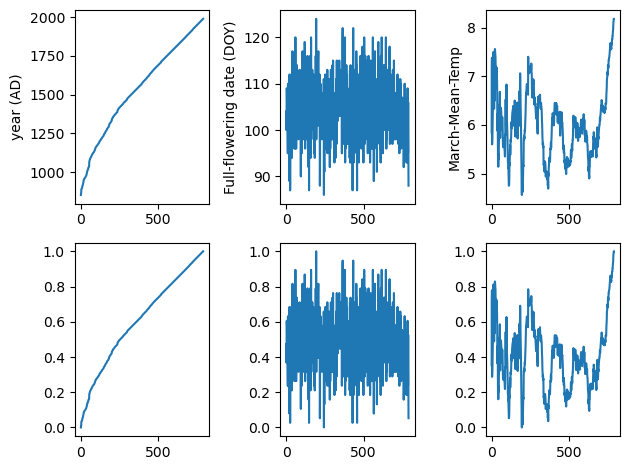

In [26]:
# visualise data before normalisation
plt.subplot(2,3,1); plt.plot(flower[:, 0]); plt.ylabel('year (AD)')
plt.subplot(2,3,2); plt.plot(flower[:, 1]); plt.ylabel('Full-flowering date (DOY)')
plt.subplot(2,3,3); plt.plot(flower[:, 2]); plt.ylabel('March-Mean-Temp')

# visulaise normalised data
plt.subplot(2,3,4); plt.plot(x[:,0]); 
plt.subplot(2,3,5); plt.plot(y)
plt.subplot(2,3,6); plt.plot(x[:,1]);

plt.tight_layout() # adjust space for axes labels

## 4. Transformation der Daten

Im nächsten Schritt müssen die Daten in ein korrektes Format gebracht werden. Teilen Sie die Daten in 80% Trainings- und 20% Testdaten und entnehmen Sie die korrekten Spalten. Für die Features werden dabei die Spalten 0 (Jahr) und 2 (Temperatur) verwendet. Die Label selber stehen mit dem Start der Kirschblüte in Spalte 1. Wenn dies abgeschlossen ist, können Sie die Daten mit der Funktion "torch.from_numpy" in Tensore umwandeln.

In [4]:
test_size = int(flower.shape[0] * 0.2) # define 20% of dataset for test set

x_train = x[test_size:]
x_test = x[:test_size]
y_train = y[test_size:]
y_test = y[:test_size]

x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()

## 5. Aufbau des neuronalen Netzes

Nun, können Sie die Definition des neuronalen Netzes vornehmen. Verwenden Sie hierzu die Klasse `ANN`, welche in der folgenden Zelle vorgegeben ist. In der `__init__()`-Methode wird dem Netz eine Inputgröße, eine Liste mit Layergrößen und eine Ausgabegröße übergeben. Überlegen Sie nun wie Sie mit diesen Informationen und beliebiger Layerzahlen ein korrekt definierte Liste von Layern erstellen können. Zur Erinnerung: `nn.linear(in_features, out_features)` erzeugt einen Neuronenlayer mit `in_features` Eingaben und `out_features` Ausgaben.

Nutzen Sie in der `forward()`-Methode nun die vorher definierte Layerliste, um die Daten korrekt durch das neuronale Netz zu leiten. Die Hidden-Layer und der Eingabe-Layer sollen die [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)-Aktivierungsfunktion und der Ausgabelayer die [Sigmoidfunktion](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) verwenden.

In [5]:
class ANN(nn.Module):
    def __init__(self, input_size, layers, output_size):
        super(ANN, self).__init__()
        self.layers = []
        next_input = input_size
        for layer in layers:
            self.layers.append(nn.Linear(next_input, layer))
            next_input = layer
        self.output = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))

        x = self.output(x)
        x = torch.sigmoid(x)
        return x

## 6. Neuronales Netz, Verlustfunktion und Optimierer anlegen

Im Folgenden kann nun eine Instanz der Netzdefinition erzeugt werden. Hier können Sie frei mit den Größen der Hidden-Layern experimentieren. Im Beispiel sollte die Eingabe allerdings zwei Neuronen und die Ausgabe ein Neuron umfassen. Nutzen Sie für die Verlustfunktion den [Mean Squared Error (MSE) Loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), eine typische Verlustfunktion für Regressionsprobleme, und für den Optimizer den stochastischen Gradientenabstieg.

In [28]:
my_network = ANN(input_size=x_train.shape[1], layers=[30, 15], output_size=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(my_network.parameters(), lr=1e-2)

## 7. Training und Test des neuronalen Netzes

Schließlich kann nun das Training ausgeführt werden. Denken Sie hierbei an die Schlüsseloperationen aus dem Buch und geben Sie mit jeder Epoche den aktuellen Verlust aus. Optional, da dies im Buch noch nicht behandelt wird, können Sie das Netz alle n-Epochen mit den Testdaten testen. Denken Sie hierbei aber daran die Berechnung von Gradienten mittels `torch.no_grad()` für das Testen auszuschalten.

In [29]:
epochs = 200 # Anzahl der Epochen festlegen

for epoch in range(epochs):
    # Forward Propagation
    y_pred = my_network(x_train)
    loss_score = criterion(y_pred, y_train)
    # Zero the gradients
    optimizer.zero_grad()
    # perform a backward pass (backpropagation)
    loss_score.backward()
    # Update the parameters
    optimizer.step()

    y_pred_np = scaler_y.inverse_transform(y_pred.detach().numpy())
    y_train_np = scaler_y.inverse_transform(y_train.detach().numpy())

    for a, (x, y) in enumerate(zip(y_pred_np[:10], y_train_np[:10])):
        print(f"{a} - Real: {y}, Pred: {x}")

    print('epoch: ', epoch, ' loss: ', loss_score.item())

0 - Real: [95.99999], Pred: [106.22279]
1 - Real: [97.], Pred: [106.2151]
2 - Real: [120.], Pred: [106.25659]
3 - Real: [102.99999], Pred: [106.240295]
4 - Real: [98.], Pred: [106.2267]
5 - Real: [105.], Pred: [106.210945]
6 - Real: [102.99999], Pred: [106.20893]
7 - Real: [100.], Pred: [106.20525]
8 - Real: [100.], Pred: [106.20308]
9 - Real: [107.], Pred: [106.27841]
epoch:  0  loss:  0.02814752608537674
0 - Real: [95.99999], Pred: [105.984795]
1 - Real: [97.], Pred: [105.97659]
2 - Real: [120.], Pred: [106.01964]
3 - Real: [102.99999], Pred: [106.00295]
4 - Real: [98.], Pred: [105.98902]
5 - Real: [105.], Pred: [105.97219]
6 - Real: [102.99999], Pred: [105.97006]
7 - Real: [100.], Pred: [105.966125]
8 - Real: [100.], Pred: [105.963646]
9 - Real: [107.], Pred: [106.04208]
epoch:  1  loss:  0.027741190046072006
0 - Real: [95.99999], Pred: [105.74891]
1 - Real: [97.], Pred: [105.74019]
2 - Real: [120.], Pred: [105.78483]
3 - Real: [102.99999], Pred: [105.76775]
4 - Real: [98.], Pred: [